In [19]:
import geopandas as gpd
import pypsa
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional
import pandas as pd

In [20]:
# all networks have same spatial resolution
REGION = "new_england" # "caiso" or "new_england"

if REGION == "caiso":
    CLUSTERS = 4
    SIMPL = 80
else:
    CLUSTERS = 6
    SIMPL = 120

NETWORK = Path("..", "..", "data", REGION, "networks", "mgas", "networks", f"elec_s{SIMPL}_c{CLUSTERS}m_ec_lv1.0_1h-TCT_E-G.nc")
SHAPES_DIR = Path("..", "..", "data", "introduction", "regions", REGION)
FIGURES = Path("..","..","figures","geospatial")

In [21]:
n = pypsa.Network(NETWORK)

INFO:pypsa.io:Imported network elec_s120_c6m_ec_lv1.0_1h-TCT_E-G.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [22]:
def plot_map(gdf: gpd.GeoDataFrame, column: str, legend_kwargs: Optional[dict[str,str]] = None) -> tuple[plt.figure, plt.axes]:
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    if not legend_kwargs:
        legend_kwargs = {}
    
    gdf.plot(column=column, linewidth=0.5, edgecolor="black", legend=True, legend_kwds=legend_kwargs, ax=ax)
    
    cbar_ax = fig.axes[-1]
    cbar_ax.tick_params(labelsize=11)
    try:
        cbar_ax.set_xlabel(legend_kwargs["label"],fontsize=12)
    except KeyError:
        pass
        
    ax.axis("off")
    
    fig.tight_layout(rect=[0, 0, 1, 1])
    
    return fig, ax

# Total Load Heatmap

In [23]:
loads_shape = gpd.read_file(Path(SHAPES_DIR, f"regions_onshore_s{SIMPL}_{CLUSTERS}m.geojson")).set_index("name")
loads_shape

,geometry
name,
p129,"POLYGON ((-73.28397 42.82446, -73.28166 42.870..."
p130,"POLYGON ((-72.3691 42.72706, -72.44966 42.7291..."
p131,"MULTIPOLYGON (((-71.69322 42.006, -71.7032 42...."
p132,"POLYGON ((-73.5862 41.16198, -73.51465 41.1982..."
p133,"MULTIPOLYGON (((-71.57894 41.19454, -71.56114 ..."
p134,"MULTIPOLYGON (((-70.9154 43.31321, -70.95175 4..."


In [24]:
loads_p = n.loads_t["p"]
loads_reeds_mapper = {x:x.split(" ")[0] for x in loads_p}
loads_p = loads_p.rename(columns=loads_reeds_mapper).T.groupby(level=0).sum().T.sum().to_frame(name="Load")
loads_p.index.name = "name"
loads_p

,Load
name,
p129,3.569263e+07
p130,6.562652e+07
p131,3.086413e+08
p132,1.571207e+08
p133,4.659831e+07
p134,9.460837e+07


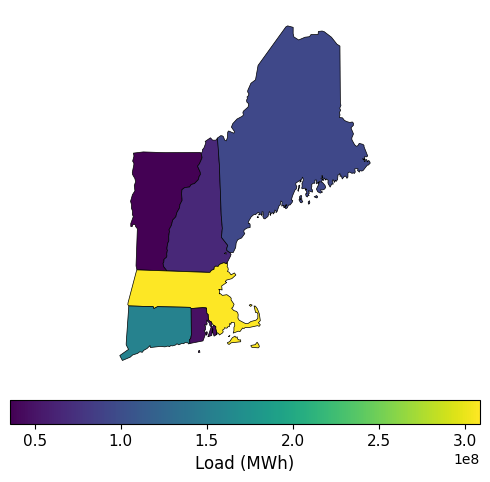

In [25]:
gdf_loads = loads_shape.join(loads_p)
legend_kwargs = {"label":"Load (MWh)", "orientation":"horizontal", "pad":0.05}
fig, _ = plot_map(gdf_loads, "Load", legend_kwargs)

fig.savefig(Path(FIGURES, f"{REGION}_load.png"), dpi=600)

# Solar Capacity Heatmap

In [26]:
solar_shape = gpd.read_file(Path(SHAPES_DIR, f"regions_onshore_s{SIMPL}.geojson")).set_index("name")
solar_shape.head()

,geometry
name,
p1290 0,"POLYGON ((-72.74259 43.72423, -72.76738 43.786..."
p1290 1,"POLYGON ((-73.17732 42.74464, -73.25958 42.746..."
p1290 2,"POLYGON ((-73.31384 44.27151, -73.31748 44.292..."
p1290 3,"POLYGON ((-72.15927 44.00757, -72.17897 44.077..."
p1290 4,"POLYGON ((-73.25131 43.47018, -73.24777 43.540..."


In [27]:
solar_gens = n.generators[n.generators.carrier == "solar"]
gens_t = n.generators_t["p_max_pu"]
gens = gens_t[[x for x in solar_gens.index if x in gens_t]]
name_mapper = {x:x.split(" solar")[0] for x in gens}
gens = gens.rename(columns=name_mapper)
gens = gens.T.groupby(level=0).mean().T.mean().to_frame(name="Capacity Factor")
gens.index.name = "name"
gens.head()

,Capacity Factor
name,
p1290 0,0.142594
p1290 1,0.144996
p1290 2,0.139612
p1290 3,0.142284
p1290 4,0.142227


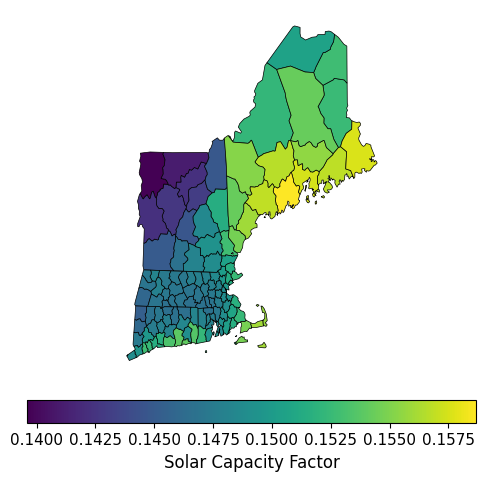

In [28]:
gdf_solar = solar_shape.join(gens)
legend_kwargs = {"label":"Solar Capacity Factor", "orientation":"horizontal", "pad":0.05}
fig, _ = plot_map(gdf_solar, "Capacity Factor", legend_kwargs)

fig.savefig(Path(FIGURES, f"{REGION}_solar.png"), dpi=600)

# Wind Capacity Heatmap

In [29]:
wind_shape_onshore = gpd.read_file(Path(SHAPES_DIR, f"regions_onshore_s{SIMPL}.geojson")).set_index("name")
wind_shape_offshore = gpd.read_file(Path(SHAPES_DIR, f"regions_offshore_s{SIMPL}.geojson")).set_index("name")

In [30]:
onshore_gens = n.generators[n.generators.carrier == "onwind"]
onshore_gens_t = n.generators_t["p_max_pu"]
on_gens = onshore_gens_t[[x for x in onshore_gens.index if x in onshore_gens_t]]
name_mapper = {x:x.split(" onwind")[0] for x in on_gens}
on_gens = on_gens.rename(columns=name_mapper)
on_gens = on_gens.T.groupby(level=0).mean().T.mean().to_frame(name="Capacity Factor")
on_gens.index.name = "name"
on_gens.head()

,Capacity Factor
name,
p1290 0,0.147106
p1290 1,0.174467
p1290 2,0.167305
p1290 3,0.134163
p1290 4,0.131897


In [31]:
offshore_gens = n.generators[n.generators.carrier == "offwind_floating"]
offshore_gens_t = n.generators_t["p_max_pu"]
off_gens = offshore_gens_t[[x for x in offshore_gens.index if x in offshore_gens_t]]
name_mapper = {x:x.split(" offwind")[0] for x in off_gens}
off_gens = off_gens.rename(columns=name_mapper)
off_gens = off_gens.T.groupby(level=0).mean().T.mean().to_frame(name="Capacity Factor")
off_gens.index.name = "name"
off_gens.head()

,Capacity Factor
name,
p1310 39,0.582392
p1320 20,0.547699
p1320 24,0.547699
p1340 10,0.597659
p1340 7,0.564455


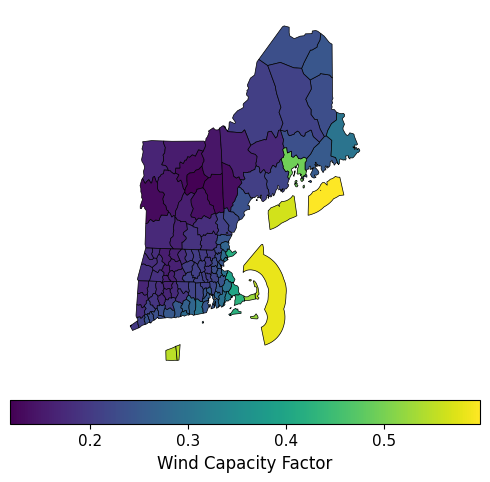

In [32]:
gdf_onwind = wind_shape_onshore.join(on_gens)
gdf_offwind = wind_shape_offshore.join(off_gens)
gdf = pd.concat([gdf_onwind, gdf_offwind])

legend_kwargs = {"label":"Wind Capacity Factor", "orientation":"horizontal", "pad":0.05}
fig, _ = plot_map(gdf, "Capacity Factor", legend_kwargs)
fig.savefig(Path(FIGURES, f"{REGION}_wind.png"), dpi=600)